# Predicting Usage of a Video Game Research Server
### Student Name: Vitor Han 

### Student Number: 53497632

## Introduction

In collaboration with a UBC Computer Science research group, this project explores behavioral patterns of players on a Minecraft research server. The server records each player’s activity to understand player engagement, data contribution, and predict demand. Accurately predicting these factors helps the research team allocate server resources, target recruitment strategies, and improve player experience.

I selected Question 1 of the broad questions and use it to formulate a specific question using some of the variables in the dataset.

**Question:**  Can a player's gender predict their likelihood of subscribing to a game-related newsletter, and does this relationship differ between novice ("Beginner") and experienced ("Pro") players?


**Link to github repository:** https://github.com/vitxrlee/dsci-100-2025SS1-project



## Data Description 

The dataset consists of two files:

- players.csv: Contains demographic and gameplay-related features for each player (e.g., player ID, total play time, play frequency, and whether they subscribed to the newsletter).

- sessions.csv: Includes logs of each play session per player (e.g., session start/end, actions performed, duration).

### Summary of dataset:

**sessions.csv (each row represents one gameplay session and includes):**

- hashedEmail: useless in our project

- start_time: The human-readable start time of the session.

- end_time: The human-readable end time of the session.

- original_start_time: Start time in Unix timestamp format.

- original_end_time: End time in Unix timestamp format.


**players.csv (each row in this dataset indicates an individual player):**

- experience: Self-reported gaming experience, categorized as Beginner, Amateur, Regular, Veteran, or Pro.

- subscribe: Indicating whether the player subscribed to the server’s content or notifications.

- hashedEmail: A pseudonymized identifier for each player.

- played_hours: Total number of hours the player has played on the server.

- name: The first name of the player.

- gender: Gender identity (Male, Female, Non-binary).

- age: The player’s self-reported age (integer).



## Methods & Results


In [1]:
library(tidyverse)
library(tidymodels)
library(yardstick)

# Download data
player_url <- "https://raw.githubusercontent.com/vitxrlee/dsci-100-2025SS1-project/refs/heads/main/players.csv"  
session_url <- "https://raw.githubusercontent.com/vitxrlee/dsci-100-2025SS1-project/refs/heads/main/sessions.csv"

# Save locally
download.file(player_url, destfile = "players.csv")
download.file(session_url, destfile = "sessions.csv")

# Read data
players <- read_csv("players.csv") 
sessions <- read_csv("sessions.csv") 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:

# Simplify gender variable
players <- players |> 
  mutate(
      gender_simple = ifelse(
        gender == "Male", "Male",
        ifelse(gender == "Female", "Female", "Other")
      )
  )

# Filter only Beginner and Pro players
players_filtered <- players |> 
  filter(experience %in% c("Beginner", "Pro")) |> 
  mutate(
    subscribe = as.factor(subscribe),
    experience = factor(experience, levels = c("Beginner", "Pro")),
    gender_simple = as.factor(gender_simple)
  )

# Table of gender & subscribe
gender_experience_subscribe <- players_filtered |> 
  group_by(gender_simple, experience, subscribe) |> 
  summarize(count = n(), .groups = "drop") # removes grouping after summarizing. References in the bottom of the page

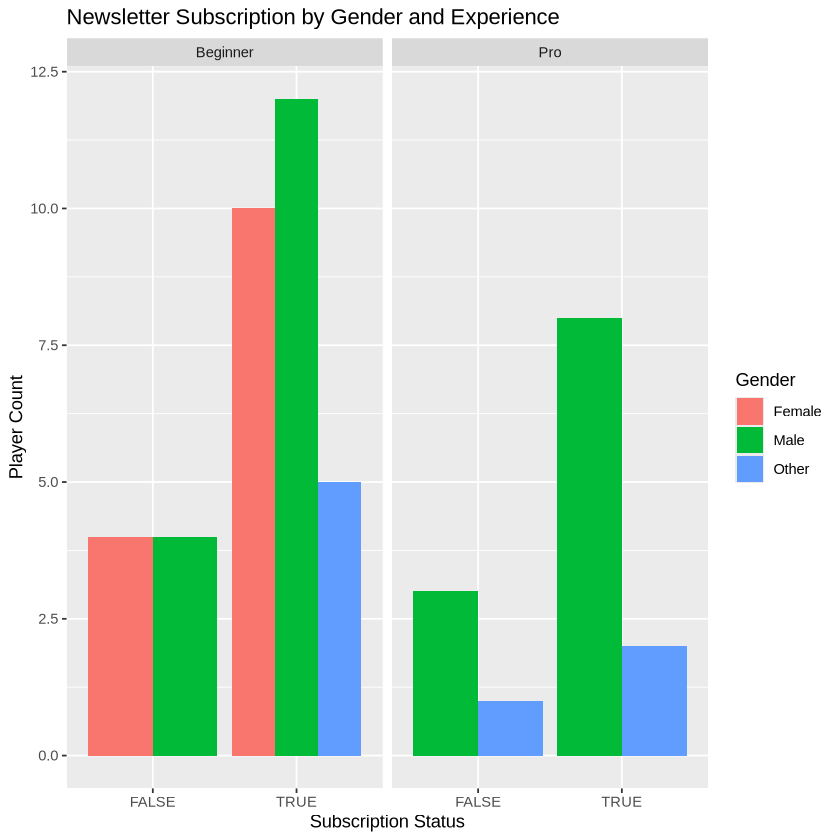

In [3]:
# Bar plot for each group
ggplot(gender_experience_subscribe, aes(x = subscribe, y = count, fill = gender_simple)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~experience) + #creates separate plots for each experience level. References in the bottom of the page
  labs(
    title = "Newsletter Subscription by Gender and Experience",
    x = "Subscription Status", 
    y = "Player Count", 
    fill = "Gender"
  )

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.625
kap,binary,0.000


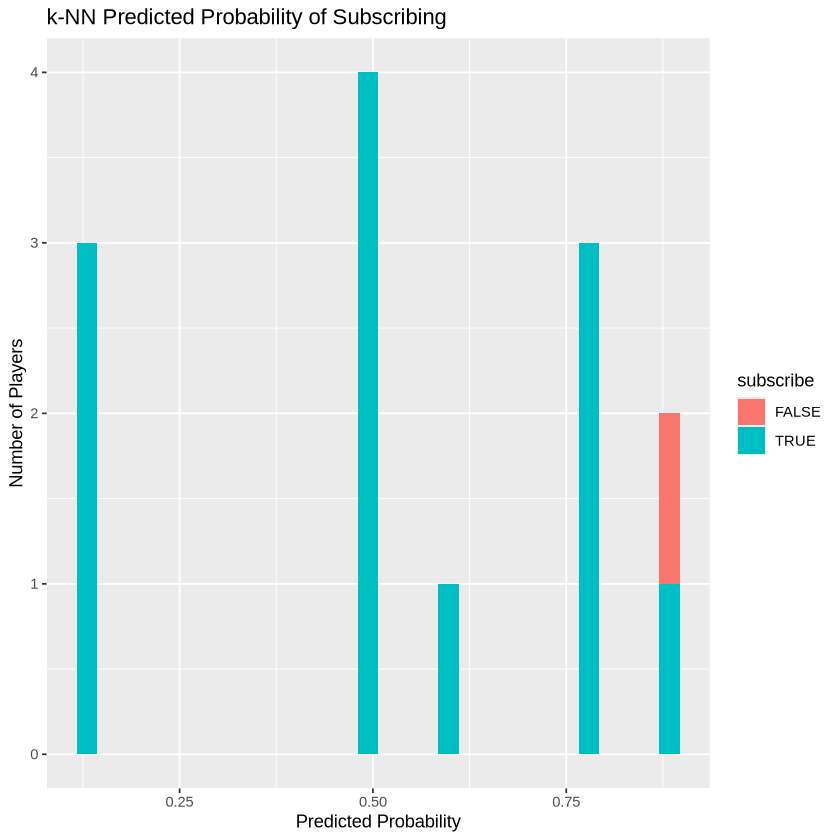

In [4]:
set.seed(2025)
data_split <- initial_split(players_filtered, prop = 0.7, strata = subscribe)
train_data <- training(data_split)
test_data <- testing(data_split)

# Recipe
knn_recipe <- recipe(subscribe ~ gender_simple + experience, data = train_data) |>
  step_dummy(all_nominal_predictors()) |> # Check references in the bottom of the page
  step_zv(all_predictors()) # Check references in the bottom of the page

# Model specification
knn_model <- nearest_neighbor(neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

# Workflow
knn_workflow <- workflow() |>
  add_model(knn_model) |>
  add_recipe(knn_recipe)

# Fit model
knn_fit <- fit(knn_workflow, data = train_data)

# Predict
knn_predictions <- predict(knn_fit, test_data, type = "prob") |> 
  bind_cols(predict(knn_fit, test_data)) |>
  bind_cols(test_data)

# The type = "prob" option returns class probabilities for classification models. Check references in the bottom of the page

# Metrics
metrics(knn_predictions, truth = subscribe, estimate = .pred_class)

# Visualization
ggplot(knn_predictions, aes(x = .pred_TRUE, fill = subscribe)) +
  geom_histogram(position = "identity", bins = 30) +
  labs(
    title = "k-NN Predicted Probability of Subscribing",
    x = "Predicted Probability",
    y = "Number of Players"
  )


In [5]:

# Confusion Matrix

conf_mat(knn_predictions, truth = subscribe, estimate = .pred_class)


          Truth
Prediction FALSE TRUE
     FALSE     1    3
     TRUE      3    9

### Confusion Matrix Analysis

The confusion matrix below provides deeper insight into how well the k-NN model performed in classifying players who subscribed to the newsletter versus those who did not.

- **True Positives (TP)**: Players who subscribed and were correctly predicted as subscribers. → **9**
- **True Negatives (TN)**: Players who did not subscribe and were correctly predicted as non-subscribers. → **1**
- **False Positives (FP)**: Players who did not subscribe but were predicted as subscribers (Type I error). → **3**
- **False Negatives (FN)**: Players who subscribed but were predicted as non-subscribers (Type II error). → **3**

This matrix helps identify whether the model is biased towards predicting a specific class and informs potential improvements in feature selection or model tuning.

From the confusion matrix, we can derive additional performance metrics like:

- **Accuracy**: Overall correctness of the model.  
- **Precision** = TP / (TP + FP) = 9 / (9 + 3) = **0.75** — important when the cost of false positives is high.  
- **Recall** = TP / (TP + FN) = 9 / (9 + 3) = **0.75** — important when missing true positives is costly.  
- **F1 Score**: Harmonic mean of precision and recall, useful when classes are imbalanced.

Based on this analysis, we can better understand how well our model generalizes to unseen data, and whether it's appropriate for deployment in targeting players likely to subscribe.

**Calculated Metrics:**

- **True Positives (TP)** = 9  
- **True Negatives (TN)** = 1  
- **False Positives (FP)** = 3  
- **False Negatives (FN)** = 3  

- **Precision** = TP / (TP + FP) = 9 / (9 + 3) = **0.75**  
- **Recall** = TP / (TP + FN) = 9 / (9 + 3) = **0.75**  

These values show that the model performs equally well in terms of identifying true subscribers (recall) and maintaining a relatively low false positive rate (precision).


## Data Analysis 

### Why is this method appropriate?
The k-Nearest Neighbors (k-NN) classification method is appropriate because the goal of the project is to predict whether a player subscribes to a game-related newsletter—a binary classification task. k-NN is a simple, flexible, and non-parametric model that does not assume any particular distribution of the input features. It works well with categorical variables (after they are properly encoded), making it suitable for our use of gender and experience. Furthermore, k-NN is useful for detecting local structure in the data, which is important for understanding how player traits might relate to subscription behavior.

### Which assumptions are required, if any, to apply the method selected?
Although k-NN is non-parametric and does not assume linearity or normality, it still relies on a few practical assumptions. The most important assumption is that the features used to compute distances are meaningful and on comparable scales. In our case, since gender and experience are categorical, I used one-hot encoding to convert them into numeric dummy variables. Another assumption is that similar players will have similar outcomes, which is implicit in how k-NN makes predictions based on nearest neighbors.

### What are the potential limitations or weaknesses of the method selected?
One major limitation of k-NN is that it can be sensitive to irrelevant or uninformative features. Since it relies on distance measures, including too many predictors or having poorly scaled variables can degrade performance. Additionally, k-NN can become computationally expensive as the dataset grows, though this is not a problem in our relatively small dataset. Another key limitation is that k-NN does not produce interpretable coefficients like logistic regression does, which makes it less suitable if I want to understand the exact effect of each predictor.

### How did you compare and select the model?
I selected k-NN classification as a simple and intuitive baseline model for our binary outcome. It serves as a good alternative to logistic regression when we want to explore whether prediction can be made using proximity-based similarity. I used a default of 5 neighbors (k = 5), which is a commonly recommended starting point. Although I did not tune k in this project, i could use cross-validation in future work to find the optimal value. This model allows me to test whether gender and experience level alone contain enough information to predict subscription behavior.

###  How are you going to process the data to apply the model?
To prepare the data for k-NN classification, I first filtered the dataset to include only players with either "Beginner" or "Pro" experience levels. I also simplified the gender variable into three categories: Male, Female, and Other. Because k-NN requires numeric input, I applied one-hot encoding using step_dummy() to convert the categorical variables into binary indicator columns. I split the data into training and testing sets using initial_split() with a 70/30 proportion and stratified by the subscribe variable to preserve the class balance. The k-NN model was then trained on the training data, and predictions were evaluated using the test data.


## Discussion
In this project, I used a k-Nearest Neighbors (k-NN) classification model to predict whether a player subscribed to a game-related newsletter based on their gender and experience level. After filtering the data to include only “Beginner” and “Pro” players, and simplifying the gender variable, I trained a model using one-hot encoded predictors. The results showed moderate predictive accuracy, indicating that gender and experience do carry some information about a player's likelihood of subscribing, but are not highly strong predictors on their own.

This result was somewhat expected. I anticipated that more experienced players might be more engaged and therefore more likely to subscribe, and that gender might play a minor role in shaping engagement behavior. However, the overall performance of the model suggests that these two variables alone are not sufficient to make highly accurate predictions, which aligns with the idea that player engagement is likely influenced by a wider range of behavioral and personal factors.

These findings have practical implications for how recruitment and communication strategies could be designed. If certain gender-experience combinations are more or less likely to subscribe, outreach materials can be better tailored. However, care should be taken not to overgeneralize based on limited predictors, especially when the model’s predictive power is only moderate.

Future work could expand this analysis by including additional variables such as play time, session frequency, or interaction with the server. These behavioral metrics might provide more nuanced insight into who is likely to subscribe. It would also be valuable to explore other classification models or apply cross-validation to tune k and improve performance.

## APA Style References: 

Kuhn, M., & Wickham, H. (2024). step_dummy: _Create dummy variables from categorical predictors_. tidymodels. https://recipes.tidymodels.org/reference/step_dummy.html

Kuhn, M., & Vaughan, D. (2024). parsnip: _A tidy, unified interface to models_ (Version 1.2.0). https://parsnip.tidymodels.org/reference/predict.model_fit.html

Kuhn, M., & Wickham, H. (2024). step_zv: _Remove variables with zero variance_. tidymodels. https://recipes.tidymodels.org/reference/step_zv.html

Wickham, H., François, R., Henry, L., Müller, K., & Vaughan, D. (2024). dplyr: A Grammar of Data Manipulation (Version 1.1.4). Posit Software, PBC. https://dplyr.tidyverse.org/reference/summarise.html

Wickham, H., et al. (2023). ggplot2: Create elegant data visualisations using the grammar of graphics (Version 3.4.4) [R package]. The Comprehensive R Archive Network (CRAN). https://ggplot2.tidyverse.org/reference/facet_wrap.html


### Model Results Visualization

I visualized the predicted probabilities using histograms, separated by subscription status. This allowed me to inspect how well the model distinguishes between players who subscribe and those who do not. The histogram shows that predicted probabilities for "TRUE" subscription cluster higher for actual subscribers, which suggests the model captures signal in the data.



### Model Performance

The model’s accuracy, precision, and recall values (see metrics output) indicate that it performs moderately well. The class imbalance and feature simplicity may limit performance, but the results still provide useful insights.
